In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns   
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

DATA CLEANING AND PREPROCESSING 

In [7]:
data = pd.read_csv("heart.csv")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


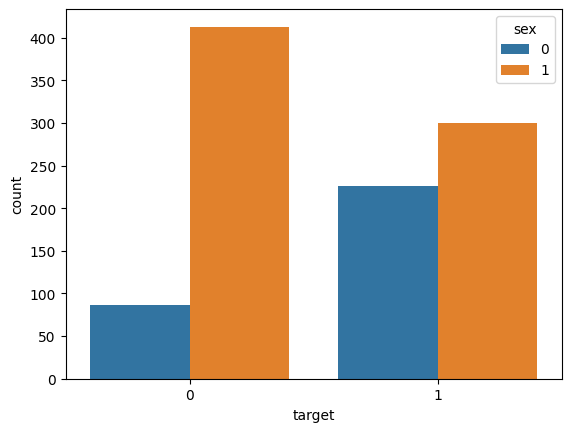

In [15]:
sns.countplot(x="target", data=data , hue="sex" )
plt.show()

In [8]:
data.shape

(1025, 14)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [10]:
x = data.drop("target", axis=1) 
y = data["target"]
    

In [11]:
x.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2


In [12]:
#split our dataset
x_train , x_test   , y_train , y_test = train_test_split(x,y,test_size=0.2,random_state=42)
#standardized our data 
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

In [24]:
print(x.shape, y.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(1025, 13) (1025,)
(820, 13) (820,)
(205, 13) (205,)


Find THE BEST PARAMETER FOR OUR ANN MODEL

In [16]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, PReLU, ELU, Activation
from tensorflow.keras import optimizers, regularizers
import tensorflow as tf

def build_model(hp):
    model = Sequential()

    # -----------------------------
    # Tune batch_size and epochs HERE
    # -----------------------------
    # These need to be defined in build_model to be tracked
    hp.Int('batch_size', 16, 128, step=16, default=32)
    hp.Int('epochs', 10, 100, step=10, default=50)

    # -----------------------------
    # Tune number of hidden layers
    # -----------------------------
    num_layers = hp.Int("num_layers", 1, 5, step=1)
    for i in range(num_layers):
        units = hp.Int(f"units_{i}", 16, 256, step=16)
        activation = hp.Choice(
            f"activation_{i}",
            [
                "sigmoid", "tanh", "relu", "leaky_relu", "prelu", "elu",
                "selu", "swish", "softmax", "gelu", "mish", "hard_swish",
                "hard_sigmoid", "linear", "binary_step"
            ]
        )
        l2_reg = hp.Float(f"l2_{i}", 0.0, 0.01, step=0.001)

        model.add(Dense(units=units, kernel_regularizer=regularizers.l2(l2_reg) if l2_reg > 0 else None))

        # Apply activation
        if activation == "leaky_relu":
            model.add(LeakyReLU())
        elif activation == "prelu":
            model.add(PReLU())
        elif activation == "elu":
            model.add(ELU())
        elif activation == "swish":
            model.add(Activation(tf.nn.swish))
        elif activation == "gelu":
            model.add(Activation(tf.nn.gelu))
        elif activation == "mish":
            model.add(Activation(lambda x: x * tf.math.tanh(tf.math.softplus(x))))
        elif activation == "hard_swish":
            model.add(Activation(tf.nn.hard_swish))
        elif activation == "binary_step":
            model.add(Activation(lambda x: tf.where(x >= 0, 1.0, 0.0)))
        else:
            model.add(Activation(activation))

        dropout_rate = hp.Float(f"dropout_{i}", 0.0, 0.5, step=0.05)
        if dropout_rate > 0:
            model.add(Dropout(rate=dropout_rate))

    # Output layer
    model.add(Dense(1, activation="sigmoid"))

    # -----------------------------
    # Tune optimizer
    # -----------------------------
    optimizer_name = hp.Choice(
        "optimizer",
        ["sgd", "momentum", "nesterov", "adagrad", "adadelta",
         "rmsprop", "adam", "adamax", "nadam", "adamw"]
    )
    lr = hp.Float("learning_rate", 1e-5, 1e-2, sampling="log")

    if optimizer_name == "sgd":
        optimizer = optimizers.SGD(learning_rate=lr)
    elif optimizer_name == "momentum":
        optimizer = optimizers.SGD(learning_rate=lr, momentum=0.9)
    elif optimizer_name == "nesterov":
        optimizer = optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
    elif optimizer_name == "adagrad":
        optimizer = optimizers.Adagrad(learning_rate=lr)
    elif optimizer_name == "adadelta":
        optimizer = optimizers.Adadelta(learning_rate=lr)
    elif optimizer_name == "rmsprop":
        optimizer = optimizers.RMSprop(learning_rate=lr)
    elif optimizer_name == "adam":
        optimizer = optimizers.Adam(learning_rate=lr)
    elif optimizer_name == "adamax":
        optimizer = optimizers.Adamax(learning_rate=lr)
    elif optimizer_name == "nadam":
        optimizer = optimizers.Nadam(learning_rate=lr)
    elif optimizer_name == "adamw":
        optimizer = optimizers.AdamW(learning_rate=lr)

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Custom tuner class to use batch_size and epochs from hyperparameters
class MyTuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        # Extract batch_size and epochs from the trial's hyperparameters
        kwargs['batch_size'] = trial.hyperparameters.get('batch_size')
        kwargs['epochs'] = trial.hyperparameters.get('epochs')
        return super(MyTuner, self).run_trial(trial, *args, **kwargs)

# -----------------------------
# Initialize tuner
# -----------------------------
tuner = MyTuner(
    build_model,
    objective="val_accuracy",
    max_trials=25,
    directory="my_tuner",
    project_name="full_model_tuning"
)

# -----------------------------
# Run hyperparameter search
# -----------------------------
tuner.search(
    x_train,
    y_train,
    validation_data=(x_test, y_test)
)

# -----------------------------
# Print best hyperparameters
# -----------------------------
best_hp = tuner.get_best_hyperparameters(1)[0]

print("\nBest Hyperparameters:")
print("---------------------")
print("Optimizer:", best_hp.get("optimizer"))
print("Learning Rate:", best_hp.get("learning_rate"))
print("Number of Layers:", best_hp.get("num_layers"))

for i in range(best_hp.get("num_layers")):
    print(f"\nLayer {i}:")
    print("  Units:", best_hp.get(f"units_{i}"))
    print("  Activation:", best_hp.get(f"activation_{i}"))
    print("  Dropout:", best_hp.get(f"dropout_{i}"))
    print("  L2:", best_hp.get(f"l2_{i}"))

print("\nTraining Configuration:")
# Handle case where batch_size and epochs might not exist in saved tuner
try:
    print("Batch Size:", best_hp.get("batch_size"))
except KeyError:
    print("Batch Size: Not tuned (using default)")

try:
    print("Epochs:", best_hp.get("epochs"))
except KeyError:
    print("Epochs: Not tuned (using default)")

Trial 25 Complete [00h 00m 06s]
val_accuracy: 0.8390243649482727

Best val_accuracy So Far: 0.8390243649482727
Total elapsed time: 00h 03m 59s

Best Hyperparameters:
---------------------
Optimizer: adamax
Learning Rate: 0.005650457279796412
Number of Layers: 1

Layer 0:
  Units: 112
  Activation: tanh
  Dropout: 0.1
  L2: 0.003

Training Configuration:
Batch Size: 16
Epochs: 50


MAKE OUR MODEL

In [25]:
x_train.shape

(820, 13)

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input , Dropout ,BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.regularizers import l2

#learning rate of our model
learning_rate = 0.005650457279796412

#Define optimizer 
optimizers = Adamax(learning_rate= learning_rate)

#Build Model
model = Sequential()
model.add(Input(shape = (13,))) 

#Layer 0
model.add(Dense(112, kernel_regularizer=l2(0.003)))
model.add(BatchNormalization())
model.add(Activation("tanh"))
model.add(Dropout(0.1))

#output layer
model.add(Dense(1,activation="sigmoid"))
#compile model
model.compile(optimizer = optimizers , loss = "binary_crossentropy", metrics = ["accuracy"])
#summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 112)            │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112)            │           448 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           113 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,129 (8.32 KB)

 Trainable params: 1,905 (7.44 KB)

 Non-trainable params: 224 (896.00 B)

Trained our model

In [29]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1   
)
model.fit(
    x_train,
    y_train,
    epochs = 50,
    validation_data = (x_test,y_test),
    callbacks = [early_stop]    
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8110 - loss: 0.4731 - val_accuracy: 0.8098 - val_loss: 0.4900
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8634 - loss: 0.4122 - val_accuracy: 0.8098 - val_loss: 0.4913
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8683 - loss: 0.3989 - val_accuracy: 0.8244 - val_loss: 0.4722
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8720 - loss: 0.3729 - val_accuracy: 0.8195 - val_loss: 0.4643
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8707 - loss: 0.3745 - val_accuracy: 0.8244 - val_loss: 0.4581
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8744 - loss: 0.3587 - val_accuracy: 0.8293 - val_loss: 0.4433
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8927 - loss: 0.3313 - val_accuracy: 0.8293 - val_loss: 0.4414
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9049 - loss: 0.3108 - val_accuracy: 0.8390 - val_loss

In [46]:
import numpy as np

new_patient_Data = np.array([[
71,0,0,112,149,0,1,125,0,1.6,1,0,2
]])

# If you used a scaler while training, apply it here:
new_patient_Data = ss.transform(new_patient_Data)

# Predict probability
pred_prop = model.predict(new_patient_Data)[0][0]

# Convert to class 0 or 1
pred_class = 1 if pred_prop >= 0.5 else 0

# Print YES / NO
if pred_class == 1:
    print("YES")
else:
    print("NO")

print("Probability:", pred_prop)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
YES
Probability: 0.99791974


c:\Users\ma516\OneDrive\Desktop\Machine Learning projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [31]:
model.save("HeartDiseasePrediction.h5")